### Chen, Cheng, Liu, and Tang (2025)

References
- **Chen, Hui, Yuhan Cheng, Yanchu Liu, and Ke Tang. 2025.** "Teaching Economics to the Machines." Available at SSRN: https://ssrn.com/abstract=4642167.
- **Lian, Tony. 2020.** "Webscraping Options Data with Python and YFinance." https://medium.com/@txlian13/webscrapping-options-data-with-python-and-yfinance-e4deb0124613.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

import datetime
from tqdm.auto import tqdm

In [ ]:
cm = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

In [ ]:
START_DATE = '2000-01-02'
END_DATE = '2023-03-31'

#### Data Collection

In [ ]:
symbol = '^SPX'
ticker = yf.Ticker(symbol)

In [ ]:
df1 = yf.download(symbol, start=START_DATE, end=END_DATE, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed

In [ ]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    exps = tk.options # expiration dates

    # Get options for each expiration.
    options = pd.DataFrame()
    for e in tqdm(exps):
        opt = tk.option_chain(e)
        data = pd.concat([opt.calls, opt.puts], ignore_index=True)
        data['expirationDate'] = pd.to_datetime(e)
        options = pd.concat([options, data], ignore_index=True)

    # Bizarre error in yfinance that gives the wrong expiration date.
    # Add 1 day to get the correct expiration date.
    options['expirationDate'] = options.expirationDate + pd.Timedelta(days=1)
    options['dte'] = (options.expirationDate - datetime.datetime.today()).dt.days / 365

    # Boolean column if the option is a CALL.
    options['CALL'] = options['contractSymbol'].str[4:].apply(lambda x: 'C' in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask

    # Drop redundant columns.
    options = options.drop(columns=['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options


In [ ]:
df = options_chain(symbol)
df_put = df.loc[~df.CALL, :].reset_index(drop=True)
df_call = df.loc[df.CALL, :].reset_index(drop=True)

  0%|          | 0/50 [00:00<?, ?it/s]

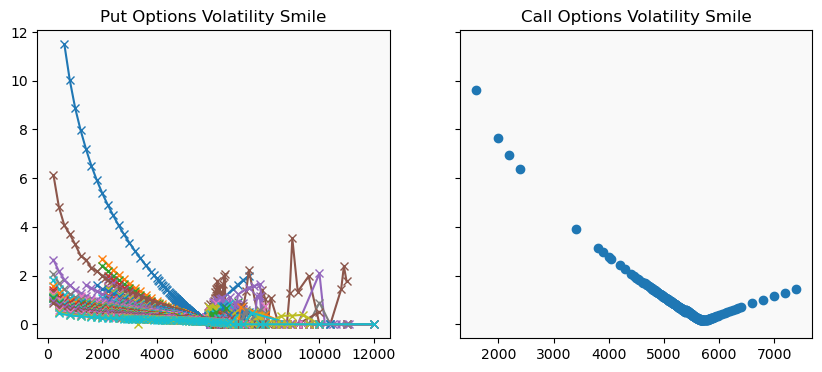

In [ ]:
# Plot the volatility smile phenomenon.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

exp_dates = df.expirationDate.unique()

# LEFT PANEL
for exp in exp_dates:
    data = df_put.loc[df_put.expirationDate == exp, ['strike', 'impliedVolatility']].sort_values(by='strike')
    ax1.plot('strike', 'impliedVolatility', data=data, marker='x')

ax1.set_title('Put Options Volatility Smile')
ax1.set_facecolor(bg)


# RIGHT PANEL
for exp in exp_dates:
    ax2.scatter(df_call.loc[df_call.expirationDate == exp, 'strike'], 
                df_call.loc[df_call.expirationDate == exp, 'impliedVolatility'])
    break

ax2.set_title('Call Options Volatility Smile')
ax2.set_facecolor(bg)

#### Generation of Synthetic Data in the Source Domain

In [ ]:
# Specify the parameters for data generation.